In [2]:
!pip install pandas

     |████████████████████████████████| 11.7 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 78.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import requests
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 120
pd.options.display.max_rows = 120

## Read ADE metadata

In [8]:
dfh = pd.read_csv('../prelim/ade20k_header.csv')
dfd = pd.read_csv('../prelim/ade20k_detail.csv')
dfd15 = pd.read_csv('../prelim/ade_coco_15pts.csv')

In [6]:
dfh.sample(5)

,header_id,width,height,filename,folder,scene
12720,8813,400,265,ADE_train_00008813.jpg,ADE20K_2021_17_01/images/ADE/training/sports_and_leisure/gymnasium__indoor,"['indoor', 'sports and leisure', 'gymnasium indoor']"
12835,9953,500,478,ADE_train_00009953.jpg,ADE20K_2021_17_01/images/ADE/training/sports_and_leisure/jacuzzi__indoor,"['indoor', 'sports and leisure', 'jacuzzi indoor']"
8277,23223,1024,680,ADE_train_00023223.jpg,ADE20K_2021_17_01/images/ADE/training/nature_landscape/creek,"['outdoor', 'nature landscape', 'creek']"
13186,24180,905,578,ADE_train_00024180.jpg,ADE20K_2021_17_01/images/ADE/training/sports_and_leisure/racecourse,"['outdoor', 'sports and leisure', 'racecourse']"
23343,18683,256,256,ADE_train_00018683.jpg,ADE20K_2021_17_01/images/ADE/training/urban/street,"['outdoor', 'urban', 'street']"


In [7]:
dfd.sample(5)

,id,raw_name,depth_ordering_rank,crop,header_id,num_mask_points,xmin,ymin,xmax,ymax,width,height
219104,72,sconce,73,0,11495,12,389,586,427,682,38,96
561529,1,building,2,0,18260,41,176,609,1454,1058,1278,449
176870,18,sink,19,0,21106,20,858,860,1280,961,422,101
289586,2,person,3,0,22930,36,425,309,503,641,78,332
517547,73,window,71,0,17343,8,1181,647,1209,752,28,105


In [130]:
dfd15.sample(5)

,Unnamed: 0,id,raw_name,depth_ordering_rank,crop,header_id,num_mask_points,xmin,ymin,xmax,ymax,width,height,coco_label
40202,40202,14,person,15,0,11830,20,312,236,322,271,10,35,person
57650,57650,11,desk,12,0,14097,27,14,281,611,481,597,200,desk
8843,8843,97,chair,98,1,7168,35,1047,686,1133,949,86,263,chair
10373,10373,58,chair,59,0,7379,69,383,845,825,1388,442,543,chair
19355,19355,27,person,28,0,239,83,549,45,782,460,233,415,person


## Grab 300 random files from dfd15. Let's call this `df300`

In [86]:
sample = dfd15.header_id.sample(n=300, random_state=52).values
df300 = dfh.loc[dfh.header_id.isin(sample)]
df300.sample(5)

,header_id,width,height,filename,folder,scene
14001,7754,1280,960,ADE_train_00007754.jpg,ADE20K_2021_17_01/images/ADE/training/transportation/ferryboat__cargo_deck,"['indoor', 'transportation', 'ferryboat cargo_deck']"
23217,18557,2200,1650,ADE_train_00018557.jpg,ADE20K_2021_17_01/images/ADE/training/urban/street,"['outdoor', 'urban', 'street']"
4116,7228,1861,1471,ADE_train_00007228.jpg,ADE20K_2021_17_01/images/ADE/training/home_or_hotel/dining_room,"['indoor', 'home or hotel', 'dining_room']"
9053,9475,1280,960,ADE_train_00009475.jpg,ADE20K_2021_17_01/images/ADE/training/nature_landscape/hot_spring,"['outdoor', 'nature landscape', 'hot_spring']"
16408,14652,285,224,ADE_train_00014652.jpg,ADE20K_2021_17_01/images/ADE/training/unclassified/outliers__saloon,"['unclassified', 'unclassified', 'unclassified']"


## Prepare tf official implementation of maskrcnn

In [14]:
!pip install tf_slim

     |████████████████████████████████| 352 kB 6.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [15]:
!pip install pycocotools

     |████████████████████████████████| 106 kB 6.8 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp38-cp38-linux_x86_64.whl size=418763 sha256=90215dbc82a9107c3c74d4643b5bafcf290727dcc8bb5eb96ba4655d12c003e6
  Stored in directory: /root/.cache/pip/wheels/dd/e2/43/3e93cd653b3346b3d702bb0509bc611189f95d60407bff1484
Successfully built pycocotools
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [16]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3328, done.
remote: Counting objects: 100% (3328/3328), done.
remote: Compressing objects: 100% (2753/2753), done.
remote: Total 3328 (delta 882), reused 1398 (delta 525), pack-reused 0
Receiving objects: 100% (3328/3328), 34.31 MiB | 2.74 MiB/s, done.
Resolving deltas: 100% (882/882), done.


In [19]:
%%bash
PROTOC_ZIP=protoc-3.14.0-linux-x86_64.zip
curl -OL https://github.com/protocolbuffers/protobuf/releases/download/v3.14.0/$PROTOC_ZIP
unzip -o $PROTOC_ZIP -d /usr/local bin/protoc
unzip -o $PROTOC_ZIP -d /usr/local 'include/*'
rm -f $PROTOC_ZIP

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   667  100   667    0     0   2991      0 --:--:-- --:--:-- --:--:--  2991
100 1604k  100 1604k    0     0  1620k      0 --:--:-- --:--:-- --:--:-- 1642k


Archive:  protoc-3.14.0-linux-x86_64.zip
  inflating: /usr/local/bin/protoc   
Archive:  protoc-3.14.0-linux-x86_64.zip
   creating: /usr/local/include/google/
   creating: /usr/local/include/google/protobuf/
  inflating: /usr/local/include/google/protobuf/wrappers.proto  
  inflating: /usr/local/include/google/protobuf/field_mask.proto  
  inflating: /usr/local/include/google/protobuf/api.proto  
  inflating: /usr/local/include/google/protobuf/struct.proto  
  inflating: /usr/local/include/google/protobuf/descriptor.proto  
  inflating: /usr/local/include/google/protobuf/timestamp.proto  
   creating: /usr/local/include/google/protobuf/compiler/
  inflating: /usr/local/include/google/protobuf/compiler/plugin.proto  
  inflating: /usr/local/include/google/protobuf/empty.proto  
  inflating: /usr/local/include/google/protobuf/any.proto  
  inflating: /usr/local/include/google/protobuf/source_context.proto  
  inflating: /usr/local/include/google/protobuf/type.proto  
  inflating: /usr/l

In [20]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [21]:
%%bash 
cd models/research
# The original notebook is broken: missing the following step of copying the setup.py
cp object_detection/packages/tf2/setup.py .
pip install .

Processing /tf/notebooks/fourthbrain/annotheta/v2/models/research
  Using cached Cython-0.29.28-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1691927 sha256=dea8f94377f57cbb2d952236a878235633fbef0826ccb7f71356777d47d238b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-i98d_vlo/wheels/51/44/32/b22f4ba4369de534584bd6caa462e3320881e88777c58e0e29
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44009 sha256=e0d42c965e3188036b16c7cedccd80146ce83c83335d89181b747f8137b6f7d2
  Stored in directory: /root/.cache/pip/wheels/bb/73/e9/d273421f5723c4bf544dcf9eb097bda94421ef8d3252699f0a
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78545 sha256=ea925b8b02b9dcaf877c17f1233b390d1c2bfe2506025873f3467010b8b72b99
  Stored in directory: /root/.cache/pip/wheels/07/35/78/e9004fa30578734db7f10e7a211605f3f0778d2bdde38a239d
  Created wheel for crcmod: filename=crcmod-1.7-cp38-cp38-linux_x86_64.whl size=35997 sha256=17425969102de805f0a7dfde7007de8b5b20a1df520858938436ebd18e88998c
  Stored in directory

  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=bd264f17b2b4e980b1f30249fb8bd9742764cab63327c8b907605424e0cb3d93
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16182 sha256=64350298fdd2eb679cacb3f560af9d7e5b46e97016c23df5fecd40d968f31c19
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22256 sha256=cca537ff11f831e94acd0df7fe6132f71426d0a5b312e22db12f32a46fa95adc
  Stored in directory: /root/.cache/pip/wheels/57/cb/6d/bab2257f26c5be4a96ff65c3d2a7122c96529b73773ee37f36
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=faba7d62bc4050533db237c0aa5af90938ba5ca44483095c92a447f7d4fb3790
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b0

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

httplib2 0.19.1 requires pyparsing<3,>=2.4.2, but you'll have pyparsing 3.0.7 which is incompatible.


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [28]:
!pip install pyparsing --upgrade --use-feature=2020-resolver
!pip install httplib2 --upgrade --use-feature=2020-resolver

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [29]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageOps
from IPython.display import display

In [30]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [31]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [32]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [33]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [58]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

727400448/727390102 [==============================] - 13s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [63]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

## Try inference on first image from df300

In [167]:
header_id, width, height, filename, folder, scene = df300.iloc[0].values
image_path = '../{}/{}'.format(folder, filename)
image_np = np.array(Image.open(image_path))
annotations = run_inference_for_single_image(masking_model, image_np)

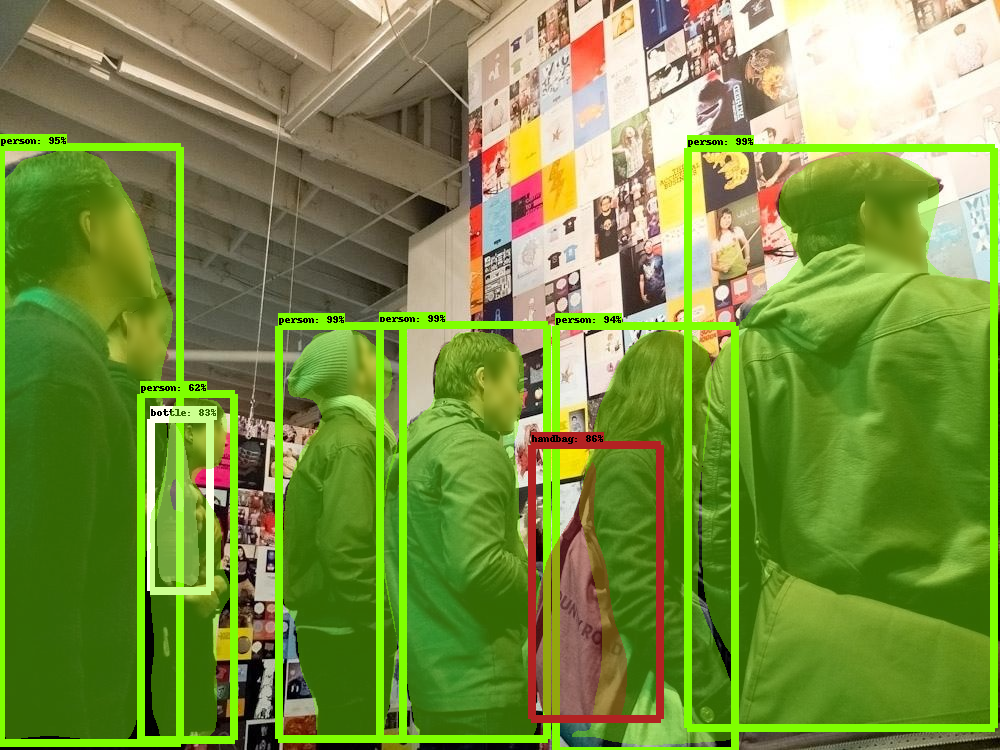

In [168]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)

display(Image.fromarray(image_np))

In [169]:
print(annotations.keys())
masks = annotations['detection_masks']
classes = annotations['detection_classes']
scores = annotations['detection_scores']
boxes = annotations['detection_boxes']
numdetects = annotations['num_detections']
masks_r = annotations['detection_masks_reframed']

boxes[0]

dict_keys(['detection_masks', 'detection_classes', 'detection_scores', 'detection_boxes', 'num_detections', 'detection_masks_reframed'])


array([0.43446586, 0.3796589 , 0.98498434, 0.54710966], dtype=float32)

In [179]:
bbox_n = boxes[1]
xmin = int(bbox_n[0] * height)
ymin = int(bbox_n[1] * width)
xmax = int(bbox_n[2] * height)
ymax = int(bbox_n[3] * width)
bbox = (xmin, ymin, xmax, ymax)
print(bbox_n, bbox)

[0.1985078  0.68758196 0.9694984  0.99454176] (148, 687, 727, 994)


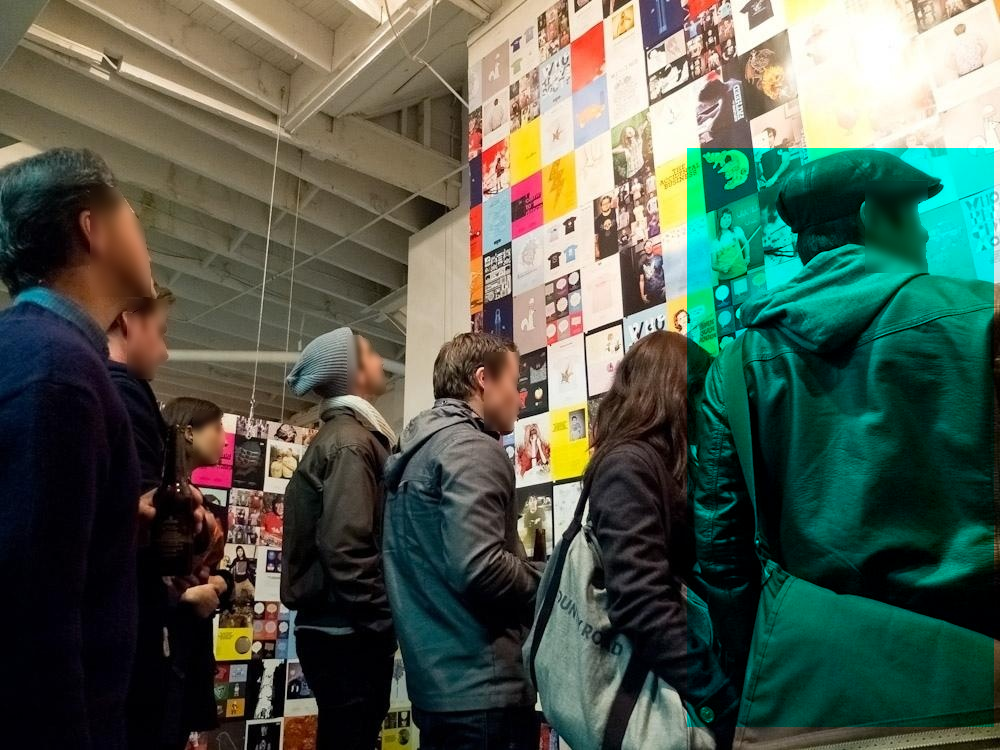

In [180]:
image_np = np.array(Image.open(image_path))
image_np[xmin:xmax, ymin:ymax, 0] = 0
display(Image.fromarray(image_np))

## Try inference on first bounding box on first image from df300

Add padding of 5% pixels.

In [374]:
dfd15.loc[dfd15.header_id==header_id]

,Unnamed: 0,id,raw_name,depth_ordering_rank,crop,header_id,num_mask_points,xmin,ymin,xmax,ymax,width,height,coco_label
188,188,6,person,7,1,22687,59,695,150,1000,698,305,548,person
189,189,8,person,9,1,22687,37,586,330,739,749,153,419,person
190,190,10,person,11,1,22687,52,382,331,543,749,161,418,person
191,191,11,person,12,1,22687,48,279,328,395,748,116,420,person
192,192,12,person,13,1,22687,48,0,147,204,749,204,602,person
193,193,13,person,14,1,22687,56,105,283,211,750,106,467,person
194,194,14,person,15,1,22687,45,151,398,233,748,82,350,person


Unnamed: 0                188
id                          6
raw_name               person
depth_ordering_rank         7
crop                        1
header_id               22687
num_mask_points            59
xmin                      695
ymin                      150
xmax                     1000
ymax                      698
width                     305
height                    548
coco_label             person
Name: 188, dtype: object


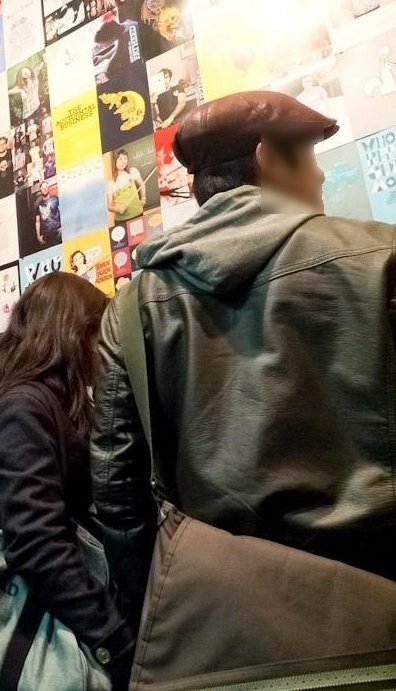

In [378]:
header_id, width, height, filename, folder, scene = df300.iloc[0].values
image_path = '../{}/{}'.format(folder, filename)
image_np = np.array(Image.open(image_path))

first_bbox = dfd15.loc[dfd15.header_id==header_id].iloc[0]
print(first_bbox)
xmin, ymin, xmax, ymax = first_bbox[['xmin', 'ymin', 'xmax', 'ymax']]

width, height = xmax-xmin, ymax-ymin
padding_pct = 0.3
padding = int(padding_pct * width if width < height else height)
image_np = image_np[ymin-padding:ymax+1+padding, xmin-padding:xmax+1+padding, :]
display(Image.fromarray(image_np))

In [379]:
image_npc = image_np.copy()
annotations = run_inference_for_single_image(masking_model, image_npc)

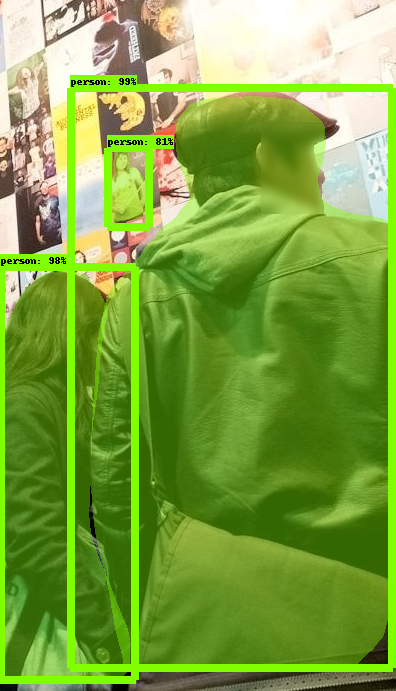

In [380]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_npc,
    annotations['detection_boxes'],
    annotations['detection_classes'],
    annotations['detection_scores'],
    category_index,
    instance_masks=annotations.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8
)
display(Image.fromarray(image_npc))

## Compare with ADE ground truth

In [160]:
print('../{}/{}'.format(folder, filename))

../ADE20K_2021_17_01/images/ADE/training/cultural/art_gallery/ADE_train_00022687.jpg


In [162]:
!ls ../ADE20K_2021_17_01/images/ADE/training/cultural/art_gallery/ADE_train_00022687.json

../ADE20K_2021_17_01/images/ADE/training/cultural/art_gallery/ADE_train_00022687.json


In [256]:
import json
import codecs

filename = '../ADE20K_2021_17_01/images/ADE/training/cultural/art_gallery/ADE_train_00022687.json'
with codecs.open(filename, 'r', encoding='utf-8', errors='ignore') as data_in:
    data = json.load(data_in)['annotation']
    the_image = next((obj for obj in data['object'] if obj['id'] == 6), None)
    print(the_image)

{'id': 6, 'name': 'person, individual, someone, somebody, mortal, soul', 'name_ndx': 1831, 'hypernym': ['person, individual, someone, somebody, mortal, soul', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity', 'entity'], 'raw_name': 'person', 'attributes': 'standing', 'depth_ordering_rank': 7, 'occluded': 'yes', 'crop': '1', 'parts': {'hasparts': [], 'ispartof': [], 'part_level': 0}, 'instance_mask': 'ADE_train_00022687/instance_006_ADE_train_00022687.png', 'polygon': {'x': [907, 887, 859, 828, 800, 782, 774, 781, 789, 791, 797, 799, 805, 793, 774, 751, 741, 739, 745, 729, 713, 701, 696, 695, 696, 702, 713, 717, 723, 732, 738, 761, 767, 774, 821, 878, 934, 966, 1000, 998, 983, 947, 934, 929, 928, 926, 927, 926, 929, 931, 922, 918, 919, 929, 941, 945, 942, 943, 928], 'y': [159, 151, 150, 155, 168, 186, 204, 222, 226, 233, 236, 252, 265, 277, 289, 299, 306, 322, 329, 348, 362, 403, 460, 530, 571, 599, 619, 651, 673, 690, 698, 59

### Looks like the gt mask is not binary

[  0 128 255]


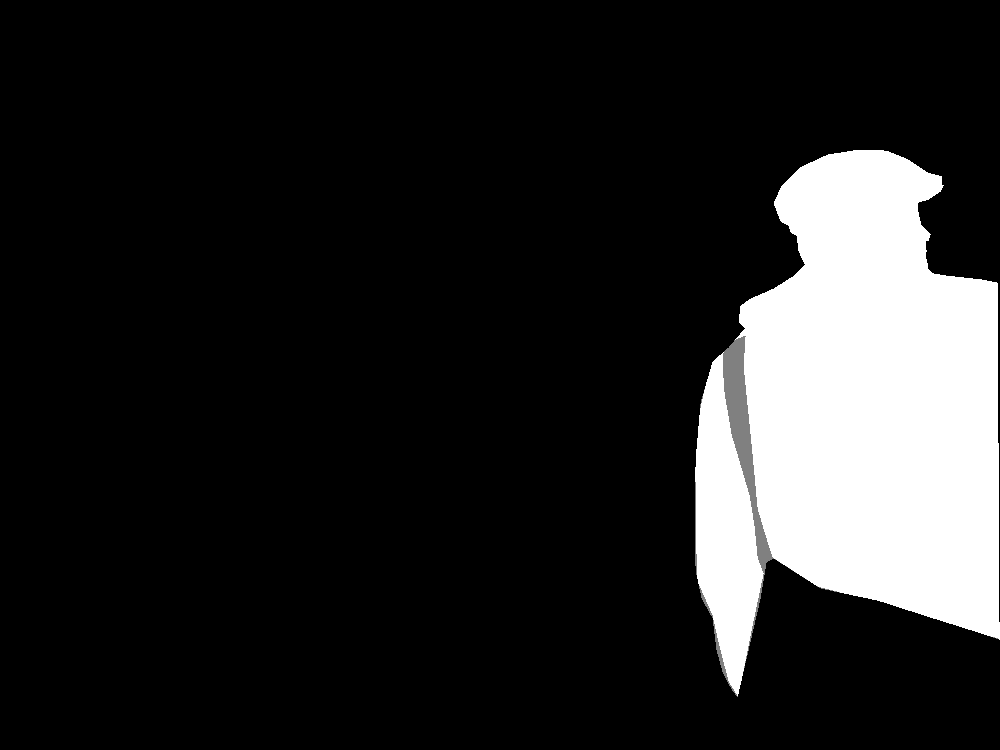

In [272]:
gt_file = '../{}/{}'.format(folder, the_image['instance_mask'])
gt_mask = np.array(Image.open(gt_file))
print(np.unique(gt_mask))
display(Image.fromarray(gt_mask))

### Make gt mask into binary: anything not black will be white

[  0 255] (750, 1000)


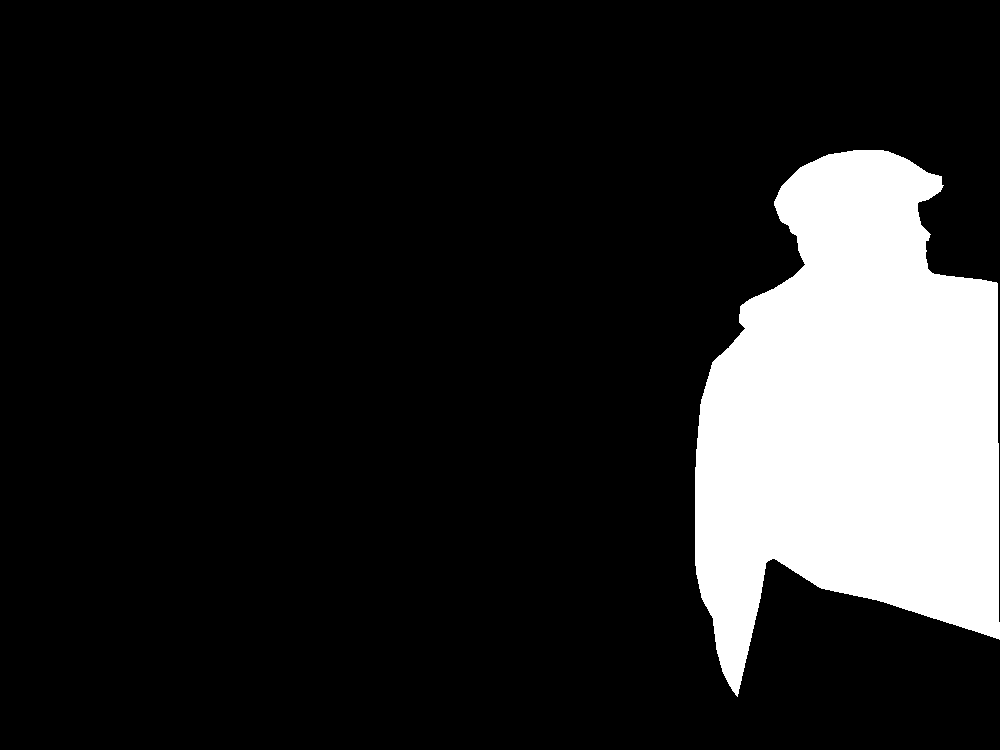

In [302]:
gt_mask[gt_mask > 0] = 255
print(np.unique(gt_mask), gt_mask.shape)
display(Image.fromarray(gt_mask))

(548, 305) 21 20 658 984


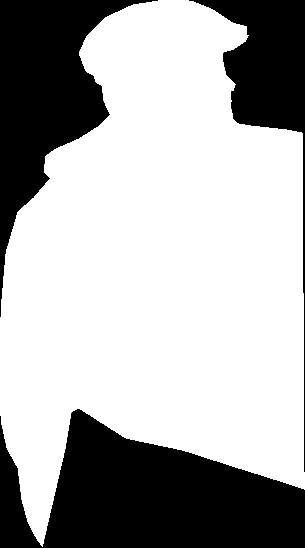

In [369]:
gt_mask1 = gt_mask[150:698, 695:1000]
print(gt_mask1.shape, xmin, ymin, xmax, ymax)
display(Image.fromarray(gt_mask1))

### Measure IoU

(579, 320) (548, 305)


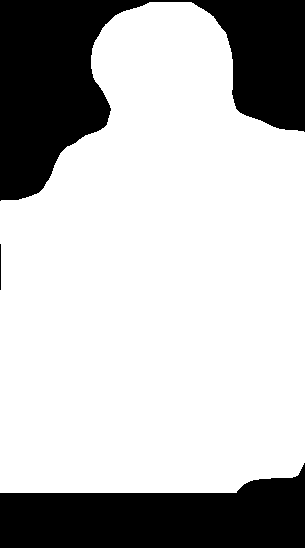

In [321]:
mask = annotations.get('detection_masks_reframed', None)[0]
height_d, width_d = mask.shape
padding_pct = 0.05
padding = int(padding_pct * width_d if width_d < height_d else height_d)
mask_p = mask.copy()
mask_p[mask_p>0] = 255
mask_p = mask_p[15:-16, 7:-8]
print(mask.shape, mask_p.shape)
display(Image.fromarray(mask_p))

In [298]:
bbox1 = annotations['detection_boxes'][0]
xmin_d = int(bbox1[0] * width_d)
ymin_d = int(bbox1[1] * height_d)
xmax_d = int(bbox1[2] * width_d)
ymax_d = int(bbox1[3] * height_d)

first_bbox = dfd15.loc[dfd15.header_id==header_id].iloc[0]
xmin_g, ymin_g, xmax_g, ymax_g = first_bbox[['xmin', 'ymin', 'xmax', 'ymax']]

print('In bounding box:', xmin_d, ymin_d, xmax_d, ymax_d, 'Width/height:', xmax_d-xmin_d, ymax_d-ymin_d)
print('In main image:', xmin_g, ymin_g, xmax_g, ymax_g, 'Width/height:', xmax_g-xmin_g, ymax_g-ymin_g)
print(xmin_g-xmin_d, ymin_g-ymin_d)

In bounding box: 9 12 281 570 Width/height: 272 558
In main image: 695 150 1000 698 Width/height: 305 548
686 138


In [324]:
filename = '../ADE20K_2021_17_01/images/ADE/training/cultural/art_gallery/ADE_train_00022687.json'
with codecs.open(filename, 'r', encoding='utf-8', errors='ignore') as data_in:
    data = json.load(data_in)['annotation']
    gt6 = next((obj for obj in data['object'] if obj['id'] == 6), None)
    print(gt6)

{'id': 6, 'name': 'person, individual, someone, somebody, mortal, soul', 'name_ndx': 1831, 'hypernym': ['person, individual, someone, somebody, mortal, soul', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity', 'entity'], 'raw_name': 'person', 'attributes': 'standing', 'depth_ordering_rank': 7, 'occluded': 'yes', 'crop': '1', 'parts': {'hasparts': [], 'ispartof': [], 'part_level': 0}, 'instance_mask': 'ADE_train_00022687/instance_006_ADE_train_00022687.png', 'polygon': {'x': [907, 887, 859, 828, 800, 782, 774, 781, 789, 791, 797, 799, 805, 793, 774, 751, 741, 739, 745, 729, 713, 701, 696, 695, 696, 702, 713, 717, 723, 732, 738, 761, 767, 774, 821, 878, 934, 966, 1000, 998, 983, 947, 934, 929, 928, 926, 927, 926, 929, 931, 922, 918, 919, 929, 941, 945, 942, 943, 928], 'y': [159, 151, 150, 155, 168, 186, 204, 222, 226, 233, 236, 252, 265, 277, 289, 299, 306, 322, 329, 348, 362, 403, 460, 530, 571, 599, 619, 651, 673, 690, 698, 59

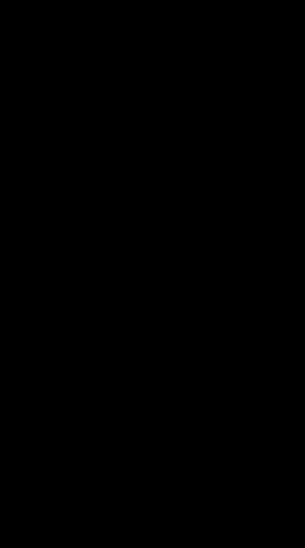

In [382]:
import cv2
X, Y = gt6['polygon']['x'], gt6['polygon']['y']
XY = np.stack((X, Y), axis=-1)
img = np.zeros((height, width, 3), np.uint8)
pts = np.array(XY, np.int32)
pts = pts.reshape((-1,1,2))
poly = cv2.polylines(img,[pts],False,(0,255,255))
display(Image.fromarray(img))